## 1.2 Early Stop

우리는 이번 실습에서 **Early Stopping**을 하는 방법에 대해서 배워보고자 합니다. Early Stop은 학습을 너무 많이 시키면 모델이 과적합(overfitting)될 수 있기 때문에 overfitting이 되지 않도록 적당한 Epoch에서 학습을 멈춰주는 정규화 방법을 말합니다. 
![earlystop](images/02_early_stop.png)
이전 실습과 대부분의 코드는 동일합니다. 

In [1]:
import math
import random 
import os 
import tensorflow as tf
import numpy as np 

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
seed = 2020
random.seed(seed)
np.random.seed(seed=seed)
tf.random.set_random_seed(seed)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape([-1, 28 * 28])
x_test = x_test.reshape([-1, 28 * 28])

m = np.random.randint(0, high=60000, size=1100, dtype=np.int64)
x_train = x_train[m]
y_train = y_train[m]

Early Stopping을 하기 위해 필요한 작업은 전체 1100개의 training data에서 validation data를 떼는 것입니다. **Training dataset 내에서 Validation dataset을 떼어낸 후에 Validation dataset 없이 학습을 진행하다가 Validation error가 가장 최적일 때의 모델 파라미터를 최종 모델로 사용합니다.** 아래 코드로 1100개의 training dataset에서 100개를 validation dataset으로 떼어냅니다. 통상적으로 10%~20%를 validation으로 떼어내는데, validation set이 너무 작으면 test set을 대변하지 못할 수도 있고 또 validation set이 너무 크면 모델 성능이 저하될 수 있으므로 적당한 수준으로 validation set을 떼어내는 작업이 중요합니다. 

In [2]:
i = np.arange(1100)
np.random.shuffle(i)
x_train = x_train[i]
y_train = y_train[i]

x_valid = x_train[:100]
y_valid = y_train[:100]

x_train = x_train[100:]
y_train = y_train[100:]

이제 나머지 부분들은 이전 실습과 동일하게 진행합니다. 

In [3]:
x = tf.placeholder(tf.float32, [None, 28 * 28])
y = tf.placeholder(tf.int32, [None])

n_units = [28 * 28, 512, 512, 10]

weights, biases = [], []
for i, (n_in, n_out) in enumerate(zip(n_units[:-1], n_units[1:])):
    stddev = math.sqrt(2 / n_in) # Kaiming He Initialization
    weight = tf.Variable(tf.random.truncated_normal([n_in, n_out], mean=0, stddev=stddev))
    bias = tf.Variable(tf.zeros([n_out]))
    weights.append(weight)
    biases.append(bias)
    
layer = x 
for i, (weight, bias) in enumerate(zip(weights, biases)):
    layer = tf.matmul(layer, weight) + bias
    if i < len(weights) - 1:
        layer = tf.nn.tanh(layer)        
y_hat = layer

y_hot = tf.one_hot(y, 10)
costs = tf.nn.softmax_cross_entropy_with_logits_v2(
        labels=y_hot, logits=y_hat)
cross_entropy_loss = tf.reduce_mean(costs)
loss = cross_entropy_loss 

accuracy = tf.count_nonzero(
        tf.cast(tf.equal(tf.argmax(y_hot, 1), tf.argmax(y_hat, 1)),
                tf.int64)) / tf.cast(tf.shape(y_hot)[0], tf.int64)

extra_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_ops):
    optimizer = tf.train.AdamOptimizer(1e-3)
    train_op = optimizer.minimize(loss)
    
gpu_options = tf.GPUOptions()
gpu_options.allow_growth = True
session = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
session.run(tf.global_variables_initializer())

각 Epoch별 train/valid/test accuracy, loss를 측정하기 위한 리스트 변수들을 선언합니다.

In [4]:
train_accuracy_values, valid_accuracy_values, test_accuracy_values = [], [], []
train_loss_values, valid_loss_values, test_loss_values = [], [], []

총 1000번의 Epoch을 수행하여 학습합니다. 만약 100 Epoch 동안 성능 개선이 이뤄지지 않으면 Early Stop 합니다. Early stop은 **accuracy** 기준으로 진행합니다.

#### TODO: Early Stopping code 추가  

In [5]:
max_valid_epoch_idx = 0
max_valid_accuracy = 0.0
final_test_accuracy = 0.0
for epoch_idx in range(0, 1000):
    session.run(
            train_op,
            feed_dict={
                x: x_train,
                y: y_train
            })
    
    if epoch_idx % 10 == 0:
        train_loss_value, train_accuracy_value = session.run(
            [loss, accuracy],
            feed_dict={
                x: x_train,
                y: y_train
            })
        
        ### (TODO) YOUR CODE HERE
    
        valid_loss_value, valid_accuracy_value = session.run(
            [loss, accuracy],
            feed_dict={
                x: x_valid,
                y: y_valid
            }
        )
     
    
        ### END YOUR CODE   
        
        test_loss_value, test_accuracy_value = session.run(
            [loss, accuracy],
            feed_dict={
                x: x_test,
                y: y_test
            })
        
        print(epoch_idx, '%.4f' % train_loss_value, '%.4f' % valid_loss_value, '%.4f' % test_loss_value, '%.4f' % train_accuracy_value,
              '%.4f' % valid_accuracy_value, '%.4f' % test_accuracy_value)
        
        train_accuracy_values.append(train_accuracy_value)
        valid_accuracy_values.append(valid_accuracy_value)
        test_accuracy_values.append(test_accuracy_value)

        train_loss_values.append(train_loss_value)
        valid_loss_values.append(valid_loss_value)
        test_loss_values.append(test_loss_value)
        
        ### (TODO) YOUR CODE HERE
        '''
        Hint: max_valid_epoch_idx, max_valid_accuracy, final_test_accuracy 변수를 사용하세요
        max_valid_epoch_idx -- 현재까지의 best validation accuracy가 등장한 epoch을 저장
        max_valid_accuracy -- 현재까지의 best validation accuracy 저장
        final_test_accuracy -- Best validation accuracy를 가지는 epoch에서의 test accuracy (Early stopping accuracy)
        '''
        if max_valid_accuracy < valid_accuracy_value:
            max_valid_accuracy = valid_accuracy_value
            max_valid_epoch_idx = epoch_idx
            final_test_accuracy = test_accuracy_value

        ### END YOUR CODE
   
    # Early Stop
    if max_valid_epoch_idx + 100 < epoch_idx:
        break
        
print("True Best Accuracy:", max(test_accuracy_values))
print("Early stopping Accuracy:", final_test_accuracy)

0 1.7915 2.0095 1.9036 0.3780 0.3100 0.3340
10 0.2083 0.5617 0.5109 0.9530 0.8200 0.8397
20 0.0513 0.4681 0.4252 0.9970 0.8400 0.8709
30 0.0171 0.4847 0.4158 1.0000 0.8500 0.8765
40 0.0086 0.5011 0.4170 1.0000 0.8600 0.8762
50 0.0056 0.4989 0.4183 1.0000 0.8600 0.8784
60 0.0042 0.5124 0.4217 1.0000 0.8600 0.8779
70 0.0034 0.5100 0.4236 1.0000 0.8700 0.8778
80 0.0029 0.5148 0.4252 1.0000 0.8700 0.8779
90 0.0026 0.5190 0.4271 1.0000 0.8700 0.8786
100 0.0023 0.5156 0.4283 1.0000 0.8600 0.8790
110 0.0020 0.5176 0.4300 1.0000 0.8700 0.8780
120 0.0019 0.5201 0.4314 1.0000 0.8600 0.8781
130 0.0017 0.5218 0.4328 1.0000 0.8600 0.8784
140 0.0016 0.5232 0.4343 1.0000 0.8600 0.8787
150 0.0014 0.5267 0.4360 1.0000 0.8600 0.8789
160 0.0013 0.5280 0.4373 1.0000 0.8600 0.8790
170 0.0012 0.5285 0.4384 1.0000 0.8600 0.8792
True Best Accuracy: 0.8792
Early stopping Accuracy: 0.8778


우리는 이 네트워크가 최고 88.09%의 Test Accuracy를 나타내고, Early Stop을 수행한 시점의 모델 성능은 87.10% 임을 확인할 수 있었습니다. 물론 최고 Test Accuracy와는 다소 차이가 있지만 Early Stopping을 통해 적당한 epoch 수를 자동으로 찾아낼 수 있었습니다. 

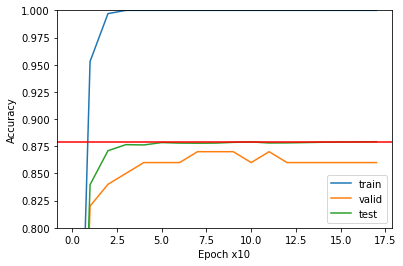

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(train_accuracy_values, label="train")
plt.plot(valid_accuracy_values, label="valid")
plt.plot(test_accuracy_values, label="test")
plt.ylabel('Accuracy')
plt.xlabel('Epoch x10')
plt.ylim([0.8, 1.0])
plt.axhline(y=max(test_accuracy_values), color='r', linestyle='-')
plt.legend(loc='lower right')
plt.show()

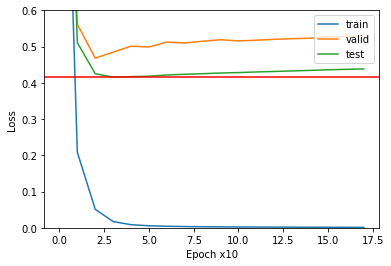

In [7]:
import matplotlib.pyplot as plt
plt.plot(train_loss_values, label="train")
plt.plot(valid_loss_values, label="valid")
plt.plot(test_loss_values, label="test")
plt.ylabel('Loss')
plt.xlabel('Epoch x10')
plt.axhline(y=min(test_loss_values), color='r', linestyle='-')
plt.ylim([0, 0.6])
plt.legend(loc='upper right')
plt.show()

Validation Set이 overfitting하기 시작하는 시점이 Test set이 overfitting하기 시작하는 시점과 상당히 유사한 것을 알 수 있습니다.  
**Quiz) Early stopping은 왜 loss 기준으로 진행하지는 않을까요?**

**Ans) 궁극적으로 원하는 메트릭은 Max accuracy이기 때문 (언제나 loss == accuracy가 아니기 때문에)**

다음 [실습](01_03_input_layer_stabilization.ipynb)에서는 Input Layer 안정화 방식에 대해서 배워보고자 합니다.